# Nettoyage des données:

In [1]:
import pandas as pd 
import numpy as np
import random
random.seed(9001)
#pour avoir toujours les memes erreurs à chaque fois qu'on re exécute le projet.

In [9]:
tab = pd.read_csv('ratings.csv')
#tab = pd.read_csv('ratings_new.csv')


In [3]:
tab.columns

Index([u'userId', u'movieId', u'rating', u'timestamp'], dtype='object')

In [4]:
useri,frequsers=np.unique(tab.userId,return_counts=True)#useri les id des users, frequsers les freq de chaque user
itemi,freqitems=np.unique(tab.movieId,return_counts=True)#itemi les id des item, freqitem les freq de chaque item
n_users=len(useri)
n_items=len(itemi)
print("le nombre des utilisateurs est :"+ str(n_users) + " Et le nombre des items est: "+ str(n_items))

le nombre des utilisateurs est :671 Et le nombre des items est: 9066



Un des problèmes qu'on a rencontré était le fait que les ids des items n'était pas ordonnée.

C'est à dire on peut trouver l'utilisateur 1,2,3,5 et 8 sans trouver les utilisateurs 4 ,6 et 7. 

Ceci nous a posé un problème dans la création de la matrice user-item parce que on risque d'avoir plusieurs lignes et colonnes vides.

Pour ça, on a crée un tableau indice_user et un tableau indice_item qui contiennent les anciens id et les nouvelles id 
par expl (1,2,5,6)=>(1,2,3,4) puis on a ajouté deux colonnes sur le tableau principale qui contient ces nouveaux IDs.

(ps) ce traitement est très couteux, pour cela on l'a lancé une seule fois, on a exporté les nouvelles ids dans un fichier csv, et à chaque fois on utilise ce nouveau fichier.


In [10]:
indice_user = pd.DataFrame()
indice_user["indice"]=range(1,len(useri)+1)
indice_user["useri"]=useri


indice_item = pd.DataFrame()
indice_item["indice"]=range(1,len(itemi)+1)
indice_item["itemi"]=itemi

In [12]:
#créer user_ID_new et Item_ID_new
x=[]
y=[]
for i in range(0,len(tab)):
    x.append((indice_user.indice[indice_user.useri==tab.userId[i]].axes[0]+1)[0])
    y.append((indice_item.indice[indice_item.itemi==tab.movieId[i]].axes[0]+1)[0])


In [25]:
tab["userIdnew"]=x
tab["movieIdnew"]=y


In [30]:
#tab.to_csv('ratings_new.csv')
tab[:20]

,userId,movieId,rating,timestamp,userIdnew,movieIdnew
0,1,31,2.5,1260759144,1,31
1,1,1029,3.0,1260759179,1,834
2,1,1061,3.0,1260759182,1,860
3,1,1129,2.0,1260759185,1,907
4,1,1172,4.0,1260759205,1,932
5,1,1263,2.0,1260759151,1,1018
6,1,1287,2.0,1260759187,1,1042
7,1,1293,2.0,1260759148,1,1048
8,1,1339,3.5,1260759125,1,1084
9,1,1343,2.0,1260759131,1,1088


In [31]:
#validation croisé:

from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(tab[["userIdnew","movieIdnew","rating"]], test_size=0.25,random_state=123)


La régle dit que si on a une grande sparsity (ou bien rareté des données, c'est de ne pas arriver à calculer la 
similarité entre 2 utilisateurs par expl si chaqu'un a aimé different items que l'autre), les modèles Model Based seront les plus efficace.
Calculant alors la sparsity:


In [32]:
sparsity=round(1.0-len(tab)/float(n_users*n_items),3)
print 'The sparsity level of our data base is ' +  str(sparsity*100) + '%'

The sparsity level of our data base is 98.4%



La pourcentage de sparsity est bien grande donc, on peut confirmer dés maintenant que les modèles Model Based seront les 
modèles les plus efficaces.

# 1. Memory based Collaboratif Filtering:

### 1.1 La mise en place du modèle:


On va commencer par créer les modèles Memory based.

    -Les modèles User-Based : "Les utilisateurs qui sont similaires à vous, ont aimé aussi ..."
    
    -Les modèles Item-Based: "Les utilisateurs qui ont aimé ça, ont aimé aussi ..."
    
Pour expliquer plus:

-le modele User-Based: va prendre un utilisateur, trouve les utilisateur les plus similaires à lui en se basant sur la note, Puis recommande les items aimé par ces utilisateurs(ça prend un user et retourne des items)

-Le modele Item-Based:prend un item, cherche les utilisateurs qui ont aimé cet item, trouve les items aimé par ces utilisateurs
(ça prend un item et retounes une liste des items)

Pour le faire, on utilisé 2 métriques le cosine similaire et cityblock.
Pour le faire, on a commencé par créer les matrice user-item train et test. Ce sont les deux matrices qui vont croisé les notes de utilsiateurs et des items.
Puis, on a créé nos 4 modèles Memory Based  
à la fin, on a créé une fonction pour faire les prédictions selon le modèle


In [35]:

train_data_matrix = np.zeros((n_users, n_items))#matrice nulle de longuer tous les users et tous les items
for line in train_data.itertuples():#parcourire la ligne col par col
    train_data_matrix[line[1]-1, line[2]-1] = line[3] 

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [36]:
#calcule de la cos similarity : (construction du modèle)
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
user_similarity1 = pairwise_distances(train_data_matrix, metric='cityblock')
item_similarity1 = pairwise_distances(train_data_matrix.T, metric='cityblock')


In [51]:

def predict(ratings, similarity, type='user'):#prend
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)#mean pour chauqe utilisateur (type = float)
        #np.newaxis pour convertir mean_user_rating de array de float en array d'array pour l'utiliser avec ratings
        #puis on a normalisé la var ratings (rating - E)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) #(type === array comme la var rating)
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)]) 
        
    x = np.zeros((n_users, n_items))
    for i in range(0,n_items):
        a=max(pred[:,i])
        b=min(pred[:,i])
        c=0
        d=5
        for j in range(0,n_users):
            x[j,i]=(pred[:,i][j]-(a-c))*d/(b-a+c)
    
    return x

In [52]:
#la prédiction avec les differents modèles:
item_prediction = predict(test_data_matrix, item_similarity, type='item')
user_prediction = predict(test_data_matrix, user_similarity, type='user')
item_prediction1 = predict(test_data_matrix, item_similarity1, type='item')
user_prediction1 = predict(test_data_matrix, user_similarity1, type='user')

### 1.2. La comparaison des RMSE:

In [53]:
#la creation de la fonction qui calcule le RMSE:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth): #Root Mean Squared Error
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #.flatten() fusionne les elts des array en un array
    #on attribue a prediction, les résultats des prédictions où on connait le vrais rating cad:
    #prediction: tous nos prédictions sur test; ground_truth.nonzero():les vrais résultats qu'on a dans test
    #on va mettre dans prediction les valeurs qu'on a prédit pour les elts qu'on adéja.
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()#pareil dans ground truth
    return sqrt(mean_squared_error(prediction, ground_truth))

In [54]:
print 'User-based CF: The RMSE for the cosine similarity metric is : ' + str(rmse(user_prediction, test_data_matrix))
print 'Item-based CF: The RMSE for the cosine similarity metric is :  ' + str(rmse(item_prediction, test_data_matrix))
print 'User-based CF: The RMSE for the cityblock similarity metric is :   ' + str(rmse(user_prediction1, test_data_matrix))
print 'Item-based CF: The RMSE for the cityblock similarity metric is : ' + str(rmse(item_prediction1, test_data_matrix))


User-based CF: The RMSE for the cosine similarity metric is : 1.4977638525
Item-based CF: The RMSE for the cosine similarity metric is :  1.50327465213
User-based CF: The RMSE for the cityblock similarity metric is :   1.5172654194
Item-based CF: The RMSE for the cityblock similarity metric is : 1.55417757528



Le meilleur modèle est celui qui a le RMSE le plus petit.

Pour notre cas c'était User based pour la métrique cosine.


Conclusion: 
    
-Les modèles Memory based sont  facile à implementer et génére des bonnes résultats.

-Ce type de modèle n'est pas scalable (n'est pas vraiment pratique dans un problème d'une grande base de donnée vu qu'il 
calcule à chaque fois la corrélation entre tous les utilisateur &/| les items) et ne resolut pas le problème de cold start(
lorsqu'on commence avec un nouveau utilisateur/item dont on n'a pas assez d'information)

Pour répondre au problème de scalability on crée les modele Model Based(partie suivante).

Pour répondre au problème de cold start, on utilise la recommandation Content based (on va pas l'utiliser vu qu'on n'a pas ces données )



# 2. Model-based Collaborative Filtering


Dans cette partie du projet, nous appliquons le deuxième sous-type du fitrage collaboratif : "Model-based". 
Il consiste à appliquer la matrice de factorisation (MF) : c'est une méthode d'apprentissage non supervisé de décomposition
et de réduction de dimensionnalité pour les variables cachées. 

Le but de la matrice de factorisation est d'apprendre les préférences cachées des utilisateurs et les attributs cachés des items
depuis les ratings connus dans notre jeu de données, pour enfin prédire les ratings inconnus en multipliant les matrices de varibales cachées des utilisateurs et des items. 

Il existe plusieurs techniques de réduction de dimensionnalité dans l'implémentation des systèmes de recommendations. 

Dans notre projet, nous avons utilisé :

- SVD : singular value decomposition

- SGD : Stochastic Gradient Descent

- ALS 



## 2.1 Singular value decomposition (SVD)

### 2.1.1 La mise en place des SVD:


Cette technique, comme toutes les autres, consiste à réduire la dimensionnalité de la matrice User-Item calculée précedemment.
Posons R la matrice User-Item de taille m x n (m : nombre de users, n: nombre d'items) et  k: la dimension de l'espace des caractères cachés.
L'équation générale de SVD est données par : R=USV^T avec:

- La matrice U des caractères cachés pour les utilisateurs : de taille m*k

- La matrice V des caractères cachés pour les items : de taille n*k

- La matrice diagonale de taille k x k avec des valeurs réelles non-negatives sur la diagonale

On peut faire la prédiction en appliquant la multiplication des 3 matrices


In [108]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#Obtenir les composantes de SVD à partir de la matrice User-Item du train. On choisit une valeur de k=20.
u, s, vt = svds(train_data_matrix, k = 100)
s_diag_matrix=np.diag(s)

In [109]:
# Multiplication des 3 matrices avec np.dot pour obtenir la matrice User_Item estimée.
X_pred = np.dot(np.dot(u, s_diag_matrix), vt) 

In [110]:
#la normalisation de X_pred vu qu'elle retourne des données qui sont pas bien distribué dans [0,5]
import math
x = np.zeros((n_users, n_items))
for i in range(0,n_items):
    a=max(X_pred[:,i])
    b=min(X_pred[:,i])
    c=0
    d=5
    for j in range(0,n_users):
        x[j,i]=(X_pred[:,i][j]-(a-c))*d/(b-a+c)
        if math.isnan(x[j,i]): x[j,i]=0

In [111]:
# Calcul de performance avec RMSE entre la matrice estimée et la matrice du test
print 'RMSE: ' + str(rmse(x, test_data_matrix))
#On a trouvé 1.49 comme RMSE, c'est plus grand que le RMSE des modèles Memory based, mais ça prend énormement moins du temps.
#Ce qu'on va dans la partie qui suit c'est d'améliorer notre modèle par le gradient stochastique et l'ALS.

RMSE: 1.46997911037


## 2.2 Stochastic Gradient Descent with Weighted Lambda Regularisation (SGD-WR)

### 2.2.1. La mise en place du modèle:

********** Algorithme SGD (Stochastic Gradient Descent) ************

Quand on utilise le filtrage collboratif pour SGD,on veut estimer 2 matrices P et Q: 

- La matrice P des caractères cachés pour les utilisateurs : de taille m*k (m: nombre d'utilisateurs, k: dimension de l'espace des caractères cachés)

- La matrice Q des caractères cachés pour les items : de taille n*k (m: nombre d'items, k: dimension de l'espace des caractères cachés)

Après l'estimation de P et Q, on peut alors prédire les ratings inconnus en multipliant les matrices P et la transposée de Q.



In [117]:
#Les matrices I et I2 serviront de matrices de sélecteur pour prendre les éléments appropriés après la création du Train et du Test
#selecteur de var est égal à 1 si la valeur dans la matrice est != 0

# matrice d'indices pour le train
I = train_data_matrix.copy()
I[I > 0] = 1
I[I == 0] = 0

# matrice d'indices pour le test
I2 = test_data_matrix.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [118]:
# La fonction prediction permet de prédire les ratings inconnus en multipliant les matrices P et la transposée de Q
def prediction(P,Q):
    return np.dot(P.T,Q)


Pour mettre à jour P et Q, on peut utiliser le SGD où on itère chaque observation dans le train pour mettre à jour P et Q au fur et à mesure: 

Q_{i+1} = Q_i + (gamma) (e{ui}*P_u - (lambda)* Q_i)

P_{i+1} = P_i + (gamma) (e{ui}*Q_u - (lambda)* P_i)

On note: 

- (gamma) la vitesse de l'apprentissage

- (lambda) le Terme de régularisation

- e :l'erreur qui est la différence entre le rating réel et le rating prédit.


In [119]:

# ****** Initialisation ******* 

lmbda = 0.1 # Terme de régularisation
k = 20 # dimension de l'espace des caractères cachés
m, n = train_data_matrix.shape  # nombre d'utilisateurs et d'items
steps = 150  # Nombre d'itération 
gamma=0.001  # vitesse d'apprentissage

P = 3 * np.random.rand(k,m) # Matrice des caractères cachés pour les utilisateurs
Q = 3 * np.random.rand(k,n) # Matrice des caractères cachés pour les items

#les matrices P et Q sont initialisées avec des valeurs aléatoires au début, mais leur contenu change à chaque itération en se 
#basant sur le train

In [120]:
""" Il existe plusieurs métriques d'évaluation, mais la plus populaire des métriques utilisée pour évaluer l'exactitude des ratings prédits
est l'erreur quadratique moyenne (RMSE) qu'on a utilisé dans notre projet :

RMSE =RacineCarrée{(1/N) * sum (r_i -estimé{r_i})^2}
"""

def rmse2(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

#R = train_data_matrix
#prediction(P,Q): estimateur du train_data_matrix avec la méthode de factorisation
#I pour prendre seulement la partie significative de la matrice (!=0)

In [121]:
#On ne considère que les valeurs !=0 
users,items = train_data_matrix.nonzero()  

In [122]:
#implémentation de the SGD-WR: (ps) cet algo prend du temps ça depend de nombre steps choisi.
train_errors = [] #stocker les erreurs du train obtenus par RMSE à chaque itération (step) 
test_errors = [] #stocker les erreurs du test obtenus par RMSE à chaque itération (step) 
     
for step in xrange(steps):
    for u, i in zip(users,items): #zip() retourne les tuples (user,item)
        e = train_data_matrix[u, i] - prediction(P[:,u],Q[:,i])  # calculer l'erreur e pour le gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # mise à jour de la matrice P
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # mise à jour de la matrice Q
        
    train_rmse = rmse2(I,train_data_matrix,Q,P) # Calcul de l'RMSE à partir du train
    test_rmse = rmse2(I2,test_data_matrix,Q,P) # Calcul de l'RMSE à partir du test
    train_errors.append(train_rmse) #à chaque itération ajouter l'erreur à la liste
    test_errors.append(test_rmse) #à chaque itération ajouter l'erreur à la liste



In [123]:
print 'RMSE : ' + str(np.mean(test_errors)) 

RMSE : 1.50060377979


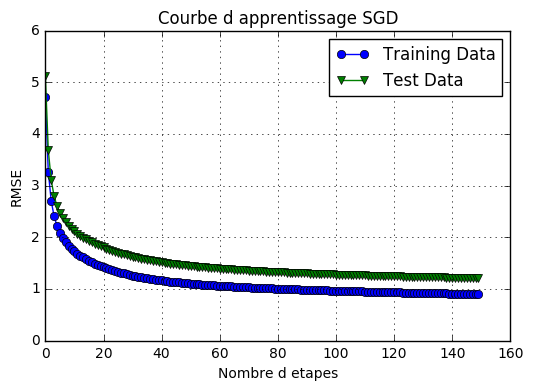

In [124]:
# Maitenant, après avoir obtenus toutes les valeurs de l'erreur à chaque étape,on peut tracer la courbe d'apprentissage.
# ==> On Vérifie la performance en traçant les erreurs du train et du test

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(steps), train_errors, marker='o', label='Training Data'); 
plt.plot(range(steps), test_errors, marker='v', label='Test Data');
plt.title('Courbe d apprentissage SGD')
plt.xlabel('Nombre d etapes');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()


Le modèle semble fonctionner bien avec,relativement, une basse valeur de RMSE après convergence.
La performance du modèle peut dépendre des paramètres (gamma), (lambda) et k qu'on a varié à plusieurs reprises afin d'obtenir 
le meilleur RMSE.

Après cette étape, on peut comparer le rating réel avec le rating estimé; Pour ce faire, on utilise la matrice User-item qu'on a 
déjà calculée et utilisé la fonction prediction(P,Q) implémentée précédemment. 



## 2.3 ALS : Alternating Least Squares

In [125]:
# Index matrix for training data
I = train_data_matrix.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = test_data_matrix.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [126]:
#ps: on n'a pas commenté car c'est presque le mm principe que le modele SGD!
lmbda = 0.1 
k = 20 
n_epochs = 2 # Nombre d'étapes
m, n = train_data_matrix.shape # Number of users and items
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent item feature matrix
Q[0,:] = train_data_matrix[train_data_matrix != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

In [127]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), train_data_matrix[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), train_data_matrix[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = rmse2(I,train_data_matrix,Q,P)
    test_rmse = rmse2(I2,test_data_matrix,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse)
    
print "Algorithm converged"

[Epoch 1/2] train error: 1.044781, test error: 1.369094
[Epoch 2/2] train error: 0.764674, test error: 1.240162
Algorithm converged


In [ ]:
"""
Conclusion:
Cet algorithme est le meilleur de tous les autres algorithmes. 
Dans 2 itération on a trouvé un erreur de train qui est égale à 1.0.764674 et un erreur de test qui est égale à 1.240162
Comme c'est l'algorithme le plus rapide et le plus efficace, On a décidé de le généralisé sur tout le jeu de données.
""""